In [1]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb

Mounted at /content/drive
/content/drive/MyDrive/Github/sales-prediction-gru/ipynb


In [2]:
import os, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Loading data

In [3]:
df = pd.read_csv('../data/fakta_penjualan_unv_202112091006.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844679 entries, 0 to 1844678
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   nonota      object 
 1   hari        int64  
 2   bulan       int64  
 3   tahun       int64  
 4   namabarang  object 
 5   satuan      object 
 6   qty         float64
 7   hargajual   float64
 8   hargabeli   float64
 9   hargajual2  float64
 10  kodejenis   object 
 11  jenis       object 
 12  barcode     object 
 13  keuntungan  float64
 14  kodecabang  float64
 15  cabang      float64
dtypes: float64(7), int64(3), object(6)
memory usage: 225.2+ MB


## Drop Column

In [5]:
df = df.drop(['nonota', 'namabarang', 'satuan', 'hargajual', 'hargabeli', 'hargajual2', 'kodejenis', 'jenis', 'keuntungan', 'kodecabang', 'cabang'], axis=1)

In [6]:
# df

## Drop Unique Symbol from Barcode Column & Convert QTY Column

In [7]:
df['barcode'] = df['barcode'].astype(str).str[:13]
df['barcode'] = df['barcode'].astype(int)
df['qty'] = df['qty'].astype(int)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1844679 entries, 0 to 1844678
Data columns (total 5 columns):
 #   Column   Dtype
---  ------   -----
 0   hari     int64
 1   bulan    int64
 2   tahun    int64
 3   qty      int64
 4   barcode  int64
dtypes: int64(5)
memory usage: 70.4 MB


## Split to Data Test & Data Train

In [9]:
test = df[df['tahun']==2019]
test.head()

,hari,bulan,tahun,qty,barcode
1096038,1,1,2019,1,8999999407919
1096039,1,1,2019,2,8999999500399
1096040,1,1,2019,1,8999999003067
1096041,1,1,2019,2,8999999045579
1096042,1,1,2019,1,8992747180225


In [10]:
years = [2016, 2017, 2018]
train = df[df.tahun.isin(years)]
train.head()

,hari,bulan,tahun,qty,barcode
65817,1,1,2016,3,8999999036607
65818,1,1,2016,1,8999999003722
65819,1,1,2016,1,8999999036898
66058,1,1,2016,3,8992747180201
66059,1,1,2016,2,8999999049034


In [11]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029983 entries, 65817 to 1096037
Data columns (total 5 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   hari     1029983 non-null  int64
 1   bulan    1029983 non-null  int64
 2   tahun    1029983 non-null  int64
 3   qty      1029983 non-null  int64
 4   barcode  1029983 non-null  int64
dtypes: int64(5)
memory usage: 47.1 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 350956 entries, 1096038 to 1446993
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   hari     350956 non-null  int64
 1   bulan    350956 non-null  int64
 2   tahun    350956 non-null  int64
 3   qty      350956 non-null  int64
 4   barcode  350956 non-null  int64
dtypes: int64(5)
memory usage: 16.1 MB


## Transform Column to Date Column

In [12]:
def column_to_date(data):
    # create date column from hari, bulan, tahun column
    cols = ["hari","bulan","tahun"]
    data['date'] = data[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
    
    # drop hari, bulan, tahun column
    data = data.drop(['hari', 'bulan', 'tahun'], axis=1)
    
    # transformn date column to datetime
    data['date'] = pd.to_datetime(data['date'])
    
    return data

In [13]:
test = column_to_date(test)
test.head()

,qty,barcode,date
1096038,1,8999999407919,2019-01-01
1096039,2,8999999500399,2019-01-01
1096040,1,8999999003067,2019-01-01
1096041,2,8999999045579,2019-01-01
1096042,1,8992747180225,2019-01-01


In [14]:
train = column_to_date(train)
train.head()

,qty,barcode,date
65817,3,8999999036607,2016-01-01
65818,1,8999999003722,2016-01-01
65819,1,8999999036898,2016-01-01
66058,3,8992747180201,2016-01-01
66059,2,8999999049034,2016-01-01


In [15]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029983 entries, 65817 to 1096037
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype         
---  ------   --------------    -----         
 0   qty      1029983 non-null  int64         
 1   barcode  1029983 non-null  int64         
 2   date     1029983 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 31.4 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 350956 entries, 1096038 to 1446993
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   qty      350956 non-null  int64         
 1   barcode  350956 non-null  int64         
 2   date     350956 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.7 MB


## Get month number from Date

In [16]:
train['month_yr'] = train['date'].apply(lambda x: x.strftime('%m-%y')).astype(str)

In [17]:
train['month_yr'] = train['month_yr'].map({'01-16':0,'02-16':1,'03-16':2,'04-16':3,'05-16':4,'06-16':5,'07-16':6,'08-16':7,'09-16':8,'10-16':9,'11-16':10,'12-16':11,
                                          '01-17':12,'02-17':13,'03-17':14,'04-17':15,'05-17':16,'06-17':17,'07-17':18,'08-17':19,'09-17':20,'10-17':21,'11-17':22,'12-17':23,
                                          '01-18':24,'02-18':25,'03-18':26,'04-18':27,'05-18':28,'06-18':29,'07-18':30,'08-18':31,'09-18':32,'10-18':33,'11-18':34,'12-18':35})

In [18]:
train['month_yr'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [19]:
print(f"Min date from data set: {test['date'].min().date()}")
print(f"Max date from data set: {test['date'].max().date()}")

Min date from data set: 2019-01-01
Max date from data set: 2019-12-31


In [20]:
print(f"Min date from data set: {train['date'].min().date()}")
print(f"Max date from data set: {train['date'].max().date()}")

Min date from data set: 2016-01-01
Max date from data set: 2018-12-31


In [21]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1029983 entries, 65817 to 1096037
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   qty       1029983 non-null  int64         
 1   barcode   1029983 non-null  int64         
 2   date      1029983 non-null  datetime64[ns]
 3   month_yr  1029983 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 39.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 350956 entries, 1096038 to 1446993
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   qty      350956 non-null  int64         
 1   barcode  350956 non-null  int64         
 2   date     350956 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.7 MB


## Prepare test dataset

Leaving only the barcode that exist in the test set to have more accurate results.
Drop kodejenis, qty and date column

In [22]:
test = test.drop(['qty', 'date'], axis=1)
test.head()

,barcode
1096038,8999999407919
1096039,8999999500399
1096040,8999999003067
1096041,8999999045579
1096042,8992747180225


In [23]:
test_barcode = test['barcode'].unique()
# Only items that exist in test set.
# train = train[train['barcode'].isin(test_barcode)]

## Data preprocessing

- We are asked to predict total sales for every product in the next month, and our data is given by day, so let's aggregate the data by month.
- Also I'm leaving only monthly "item_cnt" >= 0 and <= 20, as this seems to be the distributions of the test set.

In [24]:
train_monthly = train[['date', 'month_yr', 'barcode', 'qty']]
train_monthly = train_monthly.sort_values('date').groupby(['month_yr', 'barcode'], as_index=False)
train_monthly = train_monthly.agg({'qty':['sum']})
train_monthly.columns = ['month_yr', 'barcode', 'qty_cnt']
train_monthly = train_monthly.query('qty_cnt >= 0 and qty_cnt <= 50')

# Label
train_monthly['qty_cnt_month'] = train_monthly.sort_values('month_yr').groupby(['barcode'])['qty_cnt'].shift(-1)

display(train_monthly.head(10))
# display(train_monthly.describe())

,month_yr,barcode,qty_cnt,qty_cnt_month
0,0,4800888137319,15,23.00
1,0,4800888141101,46,41.00
3,0,4800888157942,23,21.00
4,0,4800888157959,11,13.00
5,0,4800888157966,46,37.00
6,0,4800888157973,2,8.00
8,0,8719200171411,3,4.00
10,0,8851932171403,17,9.00
11,0,8851932171427,19,7.00
12,0,8851932172264,12,13.00


In [25]:
train_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26198 entries, 0 to 33652
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month_yr       26198 non-null  int64  
 1   barcode        26198 non-null  int64  
 2   qty_cnt        26198 non-null  int64  
 3   qty_cnt_month  24888 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 1023.4 KB


## Time-Series Processing

- As I only need the "qty_cnt" feature as a series, I can get that easily by just using a pivot operation.
- This way I'll also get the missing months from each "barcode", and then replace them with 0 (otherwise would be "nan").

In [26]:
monthly_series = train_monthly.pivot_table(index=['barcode'], columns='month_yr',values='qty_cnt', fill_value=0).reset_index()
monthly_series.head()

month_yr,barcode,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,15,23,23,12,23,17,22,14,9,...,16,15,15,9,17,11,13,14,14,13
1,4800888141101,46,41,42,48,34,32,45,42,40,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,35,13,41,0,0
3,4800888157942,23,21,29,32,19,26,19,24,12,...,1,2,2,0,1,5,4,1,1,4
4,4800888157959,11,13,12,13,9,5,5,4,7,...,8,11,4,10,5,6,6,3,3,7


In [27]:
# monthly_series
# monthly_series['barcode'].unique()
# monthly_series[monthly_series.duplicated(subset=['barcode'],keep=False)]
# monthly_series.info()

Currently I have one series (35 months) for each unique pair of "barcode", but probably would be better to have multiple smaller series for each unique pair, so I'm generating multiple series of size 12 (one year) for each unique pair

In [28]:
first_month = 23
last_month = 35
serie_size = 12
data_series = []

for index, row in monthly_series.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        serie = [row['barcode']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)

columns = ['barcode']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()

,barcode,0,1,2,3,4,5,6,7,8,9,10,11,label
0,4800888137319,7,21,11,16,15,15,9,17,11,13,14,14,13
1,4800888141101,5,0,0,0,0,0,0,0,0,0,0,0,0
2,4800888141125,24,26,0,0,0,0,0,0,35,13,41,0,0
3,4800888157942,9,19,13,1,2,2,0,1,5,4,1,1,4
4,4800888157959,5,6,10,8,11,4,10,5,6,6,3,3,7


In [29]:
data_series

,barcode,0,1,2,3,4,5,6,7,8,9,10,11,label
0,4800888137319,7,21,11,16,15,15,9,17,11,13,14,14,13
1,4800888141101,5,0,0,0,0,0,0,0,0,0,0,0,0
2,4800888141125,24,26,0,0,0,0,0,0,35,13,41,0,0
3,4800888157942,9,19,13,1,2,2,0,1,5,4,1,1,4
4,4800888157959,5,6,10,8,11,4,10,5,6,6,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9300830042982,0,3,1,1,1,0,1,0,0,0,1,1,1
1306,9300830043002,0,0,3,0,1,1,0,1,0,1,4,8,10
1307,9300830043521,0,6,7,6,4,4,5,3,2,4,25,15,18
1308,9310158111567,0,1,1,3,6,5,5,5,4,11,9,5,5


## Dropping identifier columns as we don't need them anymore

In [30]:
data_series = data_series.drop(['barcode'], axis=1)
# series = monthly_series.drop(['barcode'], axis=1)

## Train and validation sets

In [31]:
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)

In [32]:
print("Train set", train.shape)
print("Validation set", valid.shape)
train.head()

Train set (1179, 12)
Validation set (131, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
184,37,0,46,37,47,41,41,47,0,9,13,8
418,27,0,45,0,0,19,20,38,44,42,45,34
295,0,0,0,0,0,0,0,0,0,0,0,0
14,5,4,8,7,10,6,19,10,15,13,2,9
1046,0,2,3,8,14,12,8,6,5,5,7,1


## Reshape data.

- Time-series shape (data points, time-steps, features).

In [33]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set reshaped (1179, 12, 1)
Validation set reshaped (131, 12, 1)


In [34]:
valid

,0,1,2,3,4,5,6,7,8,9,10,11
1139,0,13,13,9,14,11,11,25,46,32,26,25
533,0,0,0,0,0,0,0,0,0,0,0,0
459,37,46,0,40,31,38,19,50,0,29,14,13
1150,0,4,4,4,2,1,1,3,2,4,12,19
393,12,6,2,8,9,6,5,6,14,5,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
768,42,49,0,50,0,34,32,46,20,30,36,30
857,35,49,48,48,37,0,46,0,44,47,46,34
759,21,19,6,21,18,11,6,4,8,5,1,4
539,5,7,12,7,8,5,6,14,6,7,17,5


## Regular GRU model.

In [35]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

epochs = 100
batch = 32
lr = 0.0001

gru_model = Sequential()
gru_model.add(L.GRU(10, input_shape=(serie_size, n_features), return_sequences=True))
gru_model.add(L.GRU(6, activation='relu', return_sequences=True))
gru_model.add(L.GRU(1, activation='relu'))
# gru_model.add(L. Dropout(0.2)) 
gru_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
gru_model.add(L.Dense(10, kernel_initializer='glorot_normal', activation='relu'))
gru_model.add(L.Dense(1))
gru_model.summary()

adam = optimizers.Adam(lr)
gru_model.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 10)            390       
                                                                 
 gru_1 (GRU)                 (None, 12, 6)             324       
                                                                 
 gru_2 (GRU)                 (None, 1)                 27        
                                                                 
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 882
Trainable params: 882
Non-trainable pa

In [36]:
lstm_history = gru_model.fit(X_train, Y_train, 
                              validation_data=(X_valid, Y_valid), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Epoch 1/100
37/37 - 7s - loss: 265.7370 - val_loss: 301.7369 - 7s/epoch - 181ms/step
Epoch 2/100
37/37 - 1s - loss: 265.2250 - val_loss: 301.1004 - 610ms/epoch - 16ms/step
Epoch 3/100
37/37 - 1s - loss: 264.6168 - val_loss: 300.3334 - 590ms/epoch - 16ms/step
Epoch 4/100
37/37 - 1s - loss: 263.8870 - val_loss: 299.4342 - 611ms/epoch - 17ms/step
Epoch 5/100
37/37 - 1s - loss: 263.0400 - val_loss: 298.3582 - 599ms/epoch - 16ms/step
Epoch 6/100
37/37 - 1s - loss: 262.0403 - val_loss: 297.1074 - 590ms/epoch - 16ms/step
Epoch 7/100
37/37 - 1s - loss: 260.8504 - val_loss: 295.6469 - 620ms/epoch - 17ms/step
Epoch 8/100
37/37 - 1s - loss: 259.4431 - val_loss: 293.8840 - 602ms/epoch - 16ms/step
Epoch 9/100
37/37 - 1s - loss: 257.7612 - val_loss: 291.7892 - 616ms/epoch - 17ms/step
Epoch 10/100
37/37 - 1s - loss: 255.7321 - val_loss: 289.2594 - 636ms/epoch - 17ms/step
Epoch 11/100
37/37 - 1s - loss: 253.2667 - val_loss: 286.1483 - 593ms/epoch - 16ms/step
Epoch 12/100
37/37 - 1s - loss: 250.2436 - 

###### Model training

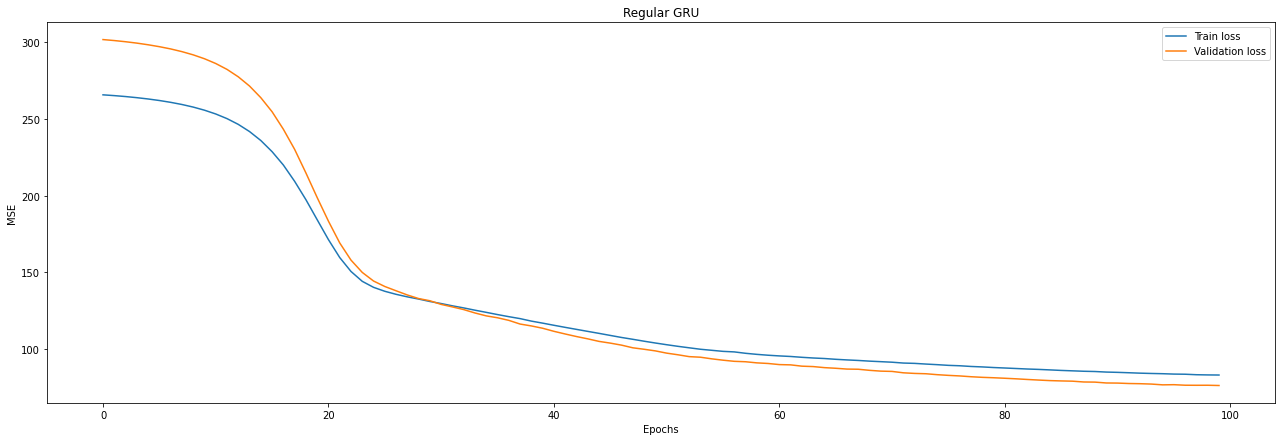

In [37]:
fig, ax1 = plt.subplots(1, sharey=True,figsize=(22,7))

ax1.plot(lstm_history.history['loss'], label='Train loss')
ax1.plot(lstm_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Regular GRU')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

plt.show()

##### Regular GRU on train and validation

In [38]:
lstm_train_pred = gru_model.predict(X_train)
lstm_val_pred = gru_model.predict(X_valid)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))

Train rmse: 9.108372557003621
Validation rmse: 8.738645300096168


In [39]:
valid

,0,1,2,3,4,5,6,7,8,9,10,11
1139,0,13,13,9,14,11,11,25,46,32,26,25
533,0,0,0,0,0,0,0,0,0,0,0,0
459,37,46,0,40,31,38,19,50,0,29,14,13
1150,0,4,4,4,2,1,1,3,2,4,12,19
393,12,6,2,8,9,6,5,6,14,5,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
768,42,49,0,50,0,34,32,46,20,30,36,30
857,35,49,48,48,37,0,46,0,44,47,46,34
759,21,19,6,21,18,11,6,4,8,5,1,4
539,5,7,12,7,8,5,6,14,6,7,17,5


In [40]:
Y_valid.shape

(131,)

In [41]:
lstm_val_pred.shape

(131, 1)

In [42]:
# fig, ax = plt.subplots()
# ax.plot(valid, Y_valid, label='Actual')
# ax.plot(valid, lstm_val_pred, label='Predicted')
# plt.title('GRU Prediction vs Actual Sales for last 3 months')
# plt.xlabel('Month')
# plt.xticks(valid)
# plt.ylabel('Sales of Barcode 4800888137319')
# ax.legend()
# plt.show()

##### Build test set

In [43]:
# cc = [test.duplicated(subset=['barcode'],keep=False)]
cc = test.groupby(test.columns.tolist(),as_index=False).size()
cc

,barcode,size
0,4800888137319,83
1,4800888141125,795
2,4800888157942,76
3,4800888157959,111
4,4800888157966,258
...,...,...
1033,9300830042913,127
1034,9300830042982,56
1035,9300830043002,20
1036,9300830043521,237


In [44]:
clean_test = test.drop_duplicates(subset=['barcode'])

In [45]:
clean_test

,barcode
1096038,8999999407919
1096039,8999999500399
1096040,8999999003067
1096041,8999999045579
1096042,8992747180225
...,...
1439870,8999999553135
1440591,8999999552541
1441150,8999999552534
1441974,8999999553111


In [46]:
monthly_series

month_yr,barcode,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,15,23,23,12,23,17,22,14,9,...,16,15,15,9,17,11,13,14,14,13
1,4800888141101,46,41,42,48,34,32,45,42,40,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,35,13,41,0,0
3,4800888157942,23,21,29,32,19,26,19,24,12,...,1,2,2,0,1,5,4,1,1,4
4,4800888157959,11,13,12,13,9,5,5,4,7,...,8,11,4,10,5,6,6,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9300830042982,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,1,1
1306,9300830043002,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,4,8,10
1307,9300830043521,0,0,0,0,0,0,0,0,0,...,6,4,4,5,3,2,4,25,15,18
1308,9310158111567,0,0,0,0,0,0,0,0,0,...,3,6,5,5,5,4,11,9,5,5


In [47]:
latest_records = monthly_series.drop_duplicates(subset=['barcode'])
X_test = pd.merge(clean_test, latest_records, on=['barcode'], how='left', suffixes=['', '_'])
X_test.fillna(0, inplace=True)
X_test.drop(['barcode'], axis=1, inplace=True)
X_test

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,47.00,44.00,42.00,45.00,28.00,0.00,26.00,29.00,37.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,49.00,0.00,39.00,0.00,0.00,35.00,47.00,15.00,16.00,39.00,...,47.00,0.00,35.00,41.00,0.00,0.00,0.00,0.00,46.00,43.00
3,0.00,0.00,0.00,44.00,50.00,48.00,0.00,44.00,39.00,0.00,...,34.00,39.00,17.00,40.00,39.00,40.00,44.00,19.00,10.00,33.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1034,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1035,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1036,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [48]:
latest_records

month_yr,barcode,0,1,2,3,4,5,6,7,8,...,26,27,28,29,30,31,32,33,34,35
0,4800888137319,15,23,23,12,23,17,22,14,9,...,16,15,15,9,17,11,13,14,14,13
1,4800888141101,46,41,42,48,34,32,45,42,40,...,0,0,0,0,0,0,0,0,0,0
2,4800888141125,0,0,0,0,0,0,0,0,49,...,0,0,0,0,0,35,13,41,0,0
3,4800888157942,23,21,29,32,19,26,19,24,12,...,1,2,2,0,1,5,4,1,1,4
4,4800888157959,11,13,12,13,9,5,5,4,7,...,8,11,4,10,5,6,6,3,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,9300830042982,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,1,1,1
1306,9300830043002,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,4,8,10
1307,9300830043521,0,0,0,0,0,0,0,0,0,...,6,4,4,5,3,2,4,25,15,18
1308,9310158111567,0,0,0,0,0,0,0,0,0,...,3,6,5,5,5,4,11,9,5,5


##### Regular LSTM model test predictions
- For the regular LSTM model we just need the last 12 months, because that's our series input size.

In [49]:
X_test = X_test[[(i + (36 - serie_size)) for i in range(serie_size)]]
X_test.head()

,24,25,26,27,28,29,30,31,32,33,34,35
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,47.00,0.00,35.00,41.00,0.00,0.00,0.00,0.00,46.00,43.00
3,40.00,41.00,34.00,39.00,17.00,40.00,39.00,40.00,44.00,19.00,10.00,33.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


##### Reshape data.
- Time-series shape (data points, time-steps, features).

In [50]:
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_test_reshaped.shape)

(1038, 12, 1)


##### Making predictions.

In [51]:
lstm_test_pred = gru_model.predict(X_test_reshaped)

##### Predictions from the regular GRU model.

In [52]:
lstm_test_pred

array([[ 2.2486262],
       [ 2.2486262],
       [23.057135 ],
       ...,
       [ 2.2486262],
       [ 2.2486262],
       [ 2.2486262]], dtype=float32)

In [53]:
lstm_prediction = pd.DataFrame(clean_test['barcode'], columns=['barcode'])
lstm_prediction['item_cnt_month'] = lstm_test_pred.clip(0., 50.)
lstm_prediction.head
# a
# lstm_prediction.to_csv('gru_submission.csv', index=False)

<bound method NDFrame.head of                barcode  item_cnt_month
1096038  8999999407919            2.25
1096039  8999999500399            2.25
1096040  8999999003067           23.06
1096041  8999999045579           22.29
1096042  8992747180225            2.25
...                ...             ...
1439870  8999999553135            2.25
1440591  8999999552541            2.25
1441150  8999999552534            2.25
1441974  8999999553111            2.25
1445435  8999999552442            2.25

[1038 rows x 2 columns]>

In [54]:
# lstm_prediction.to_csv('gru_test.csv', index=False)